In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pmdarima.arima import ndiffs
import pmdarima as pm
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA

from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [30]:
from sklearn import metrics

def scoring(y_true, y_pred):
    r2 = round(metrics.r2_score(y_true, y_pred) * 100, 3)
    mae = round(metrics.mean_absolute_error(y_true, y_pred), 3)
    corr = round(np.corrcoef(y_true, y_pred)[0,1],3)
    mape = round(metrics.mean_absolute_percentage_error(y_true, y_pred) * 100, 3)
    rmse = round(metrics.mean_squared_error(y_true, y_pred, squared=False), 3)
    rrmse = rmse / np.mean(y_true)
    
    df = pd.DataFrame({
        'R2': r2,
        'MAE' : mae,
        'Corr' : corr,
        'RMSE' : rmse,
        'RRMSE' : rrmse
        #'MAPE' : mape
    }, index=[0])
    return df

In [24]:
def set_sarimax_model(house_load_data,weather):
    house_load_data.columns = ['tmp']
    house_load_data[['no', 'time', 'familyID','state','receivingAccumulatedActiveEnergy','sendingAccumulatedActiveEnergy','receivingActivePowery','sendingActivePower','voltage','current','date']] = pd.DataFrame(house_load_data.tmp.str.split(';',11).tolist())
    house_load_data.drop('tmp',axis=1,inplace=True)
    house_load_data.drop('receivingActivePowery',axis=1,inplace=True)
    house_load_data.drop('sendingActivePower',axis=1,inplace=True)
    house_load_data.drop('sendingAccumulatedActiveEnergy',axis=1,inplace=True)
    house_load_data.drop('voltage',axis=1,inplace=True)
    house_load_data.drop('current',axis=1,inplace=True)
    
    #시계열 분해법으로 분해(시계열 형태의 ts 데이터 생성)
    timeSeries = house_load_data.loc[:,["date","time","receivingAccumulatedActiveEnergy"]]
    timeSeries.index = pd.to_datetime(timeSeries.time)
    ts = timeSeries.drop("time", axis=1)
    
    df_summary = pd.DataFrame()

    #10T : 10분, 1H : 1시간
    df_summary['power_1h_first'] = ts.receivingAccumulatedActiveEnergy.resample('1H').first()
    df_summary['power_1h_last'] = ts.receivingAccumulatedActiveEnergy.resample('1H').last()
    df_summary.fillna(method='ffill', inplace=True)
    df_summary['power'] = df_summary['power_1h_last'].astype(float)- df_summary['power_1h_first'].astype(float)
    df_summary.index.freq = '1H'
    
    list = []
    #기상청 데이터 Null 값 처리
    for i in range(1,len(weather.columns)):
        if(weather.isnull().sum()[i] == 758):
            list.append(weather.columns[i])
    
    #기상청 데이터 병합
    weather.drop(list, axis=1,inplace=True)
    weather.drop(['지점','지점명'], axis=1,inplace=True)
    df_summary.drop(['power_1h_first','power_1h_last'], axis=1,inplace=True)
    weather.rename(columns={'일시':'time'}, inplace=True)
    weather.index = pd.to_datetime(weather.time)
    weather.drop(['time'], axis=1, inplace=True)
    df_sum = pd.merge(df_summary, weather, left_index=True, right_index=True, how='left')
    df_sum.fillna(0)
    df_sum.rename(columns={'기온(°C)':'Temperature', '강수량(mm)':'precipitation','적설(cm)':'snow','지면온도(°C)':'ground_temp'}, inplace=True)
    heatmap_data = df_sum[["power","Temperature"]]
    heatmap_data.fillna(0)
    colormap = plt.cm.PuBu 
    plt.figure(figsize=(10, 8)) 
    plt.title("Correlation of Features", y = 1.05, size = 15) 
    sns.heatmap(heatmap_data.astype(float).corr(), linewidths = 0.1, vmax = 1.0, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})
    
    #다음 주기 예측 열 추가
    steps = -24
    dataset_for_prediction = heatmap_data.copy()
    dataset_for_prediction['Actual'] = dataset_for_prediction['power'].shift(steps)
    dataset_for_prediction.fillna(0, inplace=True)
    
    #Scaling
    from sklearn.preprocessing import MinMaxScaler
    sc_in = MinMaxScaler(feature_range=(0,1))
    scaled_input = sc_in.fit_transform(dataset_for_prediction[['power','Temperature']])
    scaled_input = pd.DataFrame(scaled_input)
    X = scaled_input
    sc_out = MinMaxScaler(feature_range=(0,1))
    scaler_output = sc_out.fit_transform(dataset_for_prediction[['Actual']])
    scaler_output = pd.DataFrame(scaler_output)
    y = scaler_output
    X.rename(columns={0:'power',1:'Temperature'},inplace=True)
    y.rename(columns={0:'power Next Day'}, inplace=True)
    y.index = dataset_for_prediction.index
    train_size = int(len(df_sum) * 0.7)
    test_size = int(len(df_sum)) - train_size
    train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
    test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()
    
    #AIC
    from pmdarima.arima import auto_arima
    step_wise = auto_arima(train_y,
                          exogenous = train_X,
                          start_p=1,
                          start_q=1,
                          max_p=7,
                          max_q=7, D=1, 
                          start_P=1,
                          start_Q=1,
                           m=24,
                          trace=True, error_action='ignore',
                           seasonal=True,
                          suppress_warnings=True,
                          stepwise=True)
    
    print(step_wise.summary())

In [78]:
house_load_data = pd.read_csv("./etri_ess_house_data_220211/load_house_2022/house_load_6-1_2201.csv")

,136289660;2022-01-06 12:57:02;6-1;N;7332800;4224180;0;1055;229090;4580;2022-01-06 12:57:02
0,136289709;2022-01-06 12:57:12;6-1;N;7332800;42...
1,136289802;2022-01-06 12:57:32;6-1;N;7332800;42...
2,136289846;2022-01-06 12:57:42;6-1;N;7332800;42...
3,136289934;2022-01-06 12:58:02;6-1;N;7332800;42...
4,136289991;2022-01-06 12:58:14;6-1;N;7332800;42...
...,...
137385,146503514;2022-01-31 23:58:49;6-1;N;7674540;43...
137386,146503572;2022-01-31 23:59:01;6-1;N;7674540;43...
137387,146503649;2022-01-31 23:59:19;6-1;N;7674540;43...
137388,146503709;2022-01-31 23:59:33;6-1;N;7674540;43...


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[24] intercept   : AIC=inf, Time=15.80 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=-543.552, Time=0.33 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=-648.929, Time=7.38 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=12.83 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=-545.548, Time=0.64 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=-623.833, Time=1.49 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=-720.281, Time=37.23 sec
 ARIMA(1,0,0)(2,1,1)[24] intercept   : AIC=-720.855, Time=57.12 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=14.83 sec
 ARIMA(1,0,0)(2,1,2)[24] intercept   : AIC=inf, Time=58.10 sec
 ARIMA(1,0,0)(1,1,2)[24] intercept   : AIC=inf, Time=54.62 sec
 ARIMA(0,0,0)(2,1,1)[24] intercept   : AIC=-651.571, Time=46.52 sec
 ARIMA(2,0,0)(2,1,1)[24] intercept   : AIC=-718.541, Time=60.78 sec
 ARIMA(1,0,1)(2,1,1)[24] intercept   : AIC=-716.865, Time=62.76 sec
 ARIMA(0,0,1)(2,1,1)[24] intercept

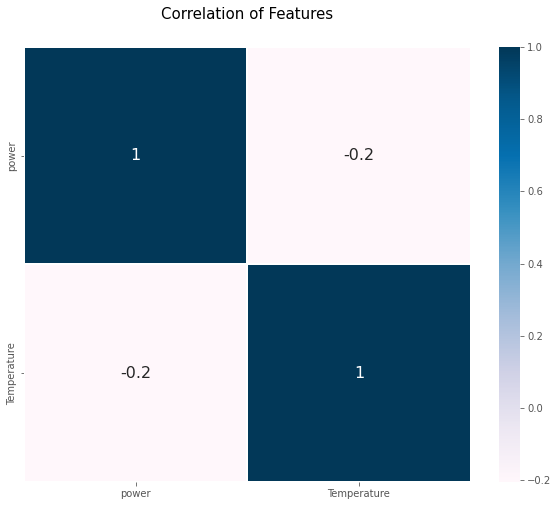

In [25]:
weather = pd.read_csv("weather.csv", encoding='cp949')
house_load_data = pd.read_csv("./etri_ess_house_data_220211/load_house_2022/house_load_6-1_2201.csv")
set_sarimax_model(house_load_data, weather)

In [66]:
def prediction_test(house_load_data, weather, order, seasonal_order):
    house_load_data.columns = ['tmp']
    house_load_data[['no', 'time', 'familyID','state','receivingAccumulatedActiveEnergy','sendingAccumulatedActiveEnergy','receivingActivePowery','sendingActivePower','voltage','current','date']] = pd.DataFrame(house_load_data.tmp.str.split(';',11).tolist())
    house_load_data.drop('tmp',axis=1,inplace=True)
    house_load_data.drop('receivingActivePowery',axis=1,inplace=True)
    house_load_data.drop('sendingActivePower',axis=1,inplace=True)
    house_load_data.drop('sendingAccumulatedActiveEnergy',axis=1,inplace=True)
    house_load_data.drop('voltage',axis=1,inplace=True)
    house_load_data.drop('current',axis=1,inplace=True)
    
    #시계열 분해법으로 분해(시계열 형태의 ts 데이터 생성)
    timeSeries = house_load_data.loc[:,["date","time","receivingAccumulatedActiveEnergy"]]
    timeSeries.index = pd.to_datetime(timeSeries.time)
    ts = timeSeries.drop("time", axis=1)
    
    df_summary = pd.DataFrame()

    #10T : 10분, 1H : 1시간
    df_summary['power_1h_first'] = ts.receivingAccumulatedActiveEnergy.resample('1H').first()
    df_summary['power_1h_last'] = ts.receivingAccumulatedActiveEnergy.resample('1H').last()
    df_summary.fillna(method='ffill', inplace=True)
    df_summary['power'] = df_summary['power_1h_last'].astype(float)- df_summary['power_1h_first'].astype(float)
    df_summary.index.freq = '1H'
    
    list = []
    #기상청 데이터 Null 값 처리
    for i in range(1,len(weather.columns)):
        if(weather.isnull().sum()[i] == 758):
            list.append(weather.columns[i])
    
    #기상청 데이터 병합
    weather.drop(list, axis=1,inplace=True)
    weather.drop(['지점','지점명'], axis=1,inplace=True)
    df_summary.drop(['power_1h_first','power_1h_last'], axis=1,inplace=True)
    weather.rename(columns={'일시':'time'}, inplace=True)
    weather.index = pd.to_datetime(weather.time)
    weather.drop(['time'], axis=1, inplace=True)
    df_sum = pd.merge(df_summary, weather, left_index=True, right_index=True, how='left')
    df_sum.fillna(0)
    df_sum.rename(columns={'기온(°C)':'Temperature', '강수량(mm)':'precipitation','적설(cm)':'snow','지면온도(°C)':'ground_temp'}, inplace=True)
    heatmap_data = df_sum[["power","Temperature"]]
    heatmap_data.fillna(0)
    
    #다음 주기 예측 열 추가
    steps = -24
    dataset_for_prediction = heatmap_data.copy()
    dataset_for_prediction['Actual'] = dataset_for_prediction['power'].shift(steps)
    dataset_for_prediction.fillna(0, inplace=True)
    
    #Scaling
    from sklearn.preprocessing import MinMaxScaler
    sc_in = MinMaxScaler(feature_range=(0,1))
    scaled_input = sc_in.fit_transform(dataset_for_prediction[['power','Temperature']])
    scaled_input = pd.DataFrame(scaled_input)
    X = scaled_input
    sc_out = MinMaxScaler(feature_range=(0,1))
    scaler_output = sc_out.fit_transform(dataset_for_prediction[['Actual']])
    scaler_output = pd.DataFrame(scaler_output)
    y = scaler_output
    X.rename(columns={0:'power',1:'Temperature'},inplace=True)
    y.rename(columns={0:'power Next Day'}, inplace=True)
    y.index = dataset_for_prediction.index
    train_size = int(len(df_sum) * 0.7)
    test_size = int(len(df_sum)) - train_size
    train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
    test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()
    
    #예측
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    model = SARIMAX(train_y.values.reshape(-1,1), 
                    exog=train_X, 
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_invertibility=False, enforce_stationarity=False)
    results = model.fit(trend='nc') #nc : 상수항 제거
    predictions = results.predict(start = train_size, end= train_size + test_size + (steps)-1 +24, exog=test_X)
    act = pd.DataFrame(scaler_output.iloc[train_size:,0])
    act.index = test_X.index
    predictions=pd.DataFrame(predictions)
    predictions.reset_index(drop=True, inplace=True)
    predictions.index=test_X.index
    predictions['Actual'] = act['power Next Day']
    predictions.rename(columns={'predicted_mean':'Pred'}, inplace=True)
    
    predictions['Actual'].plot(figsize=(20,8), legend=True, color='blue')
    predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))
    
    scoring(predictions['Actual'], predictions['Pred'])
    
    #inverse transformation
    lstm_predictions = sc_out.inverse_transform(predictions)
    
    df = pd.DataFrame(lstm_predictions)
    df.index = test_X.index
    return df

In [111]:
def prediction(house_load_data, weather, order, seasonal_order):
    house_load_data.columns = ['tmp']
    house_load_data[['no', 'time', 'familyID','state','receivingAccumulatedActiveEnergy','sendingAccumulatedActiveEnergy','receivingActivePowery','sendingActivePower','voltage','current','date']] = pd.DataFrame(house_load_data.tmp.str.split(';',11).tolist())
    house_load_data.drop('tmp',axis=1,inplace=True)
    house_load_data.drop('receivingActivePowery',axis=1,inplace=True)
    house_load_data.drop('sendingActivePower',axis=1,inplace=True)
    house_load_data.drop('sendingAccumulatedActiveEnergy',axis=1,inplace=True)
    house_load_data.drop('voltage',axis=1,inplace=True)
    house_load_data.drop('current',axis=1,inplace=True)
    familyID = house_load_data.familyID[0]
    
    #시계열 분해법으로 분해(시계열 형태의 ts 데이터 생성)
    timeSeries = house_load_data.loc[:,["date","time","receivingAccumulatedActiveEnergy"]]
    timeSeries.index = pd.to_datetime(timeSeries.time)
    ts = timeSeries.drop("time", axis=1)
    
    df_summary = pd.DataFrame()

    #10T : 10분, 1H : 1시간
    df_summary['power_1h_first'] = ts.receivingAccumulatedActiveEnergy.resample('1H').first()
    df_summary['power_1h_last'] = ts.receivingAccumulatedActiveEnergy.resample('1H').last()
    df_summary.fillna(method='ffill', inplace=True)
    df_summary['power'] = df_summary['power_1h_last'].astype(float)- df_summary['power_1h_first'].astype(float)
    df_summary.index.freq = '1H'
    
    list = []
    #기상청 데이터 Null 값 처리
    for i in range(1,len(weather.columns)):
        if(weather.isnull().sum()[i] == 758):
            list.append(weather.columns[i])
    
    #기상청 데이터 병합
    weather.drop(list, axis=1,inplace=True)
    weather.drop(['지점','지점명'], axis=1,inplace=True)
    df_summary.drop(['power_1h_first','power_1h_last'], axis=1,inplace=True)
    weather.rename(columns={'일시':'time'}, inplace=True)
    weather.index = pd.to_datetime(weather.time)
    weather.drop(['time'], axis=1, inplace=True)
    df_sum = pd.merge(df_summary, weather, left_index=True, right_index=True, how='left')
    df_sum.fillna(0)
    df_sum.rename(columns={'기온(°C)':'Temperature', '강수량(mm)':'precipitation','적설(cm)':'snow','지면온도(°C)':'ground_temp'}, inplace=True)
    heatmap_data = df_sum[["power","Temperature"]]
    heatmap_data.fillna(0)
    
    #다음 주기 예측 열 추가
    steps = -24
    dataset_for_prediction = heatmap_data.copy()
    dataset_for_prediction['Actual'] = dataset_for_prediction['power'].shift(steps)
    dataset_for_prediction.fillna(0, inplace=True)
    #dataset_for_prediction = dataset_for_prediction.dropna()
    
    #Scaling
    from sklearn.preprocessing import MinMaxScaler
    sc_in = MinMaxScaler(feature_range=(0,1))
    scaled_input = sc_in.fit_transform(dataset_for_prediction[['power','Temperature']])
    scaled_input = pd.DataFrame(scaled_input)
    X = scaled_input
    sc_out = MinMaxScaler(feature_range=(0,1))
    scaler_output = sc_out.fit_transform(dataset_for_prediction[['Actual']])
    scaler_output = pd.DataFrame(scaler_output)
    y = scaler_output
    X.rename(columns={0:'power',1:'Temperature'},inplace=True)
    y.rename(columns={0:'power Next Day'}, inplace=True)
    y.index = dataset_for_prediction.index
    train_size = int(len(df_sum) * 0.7)
    test_size = int(len(df_sum)) - train_size
    train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
    test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()
    
    #예측
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    model = SARIMAX(y.values.reshape(-1,1), 
                    exog=X, 
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_invertibility=False, enforce_stationarity=False)
    results = model.fit(trend='nc') #nc : 상수항 제거
    predictions = results.predict(start = 0, end= len(y) + (steps)-1+24, exog=X)
    act = pd.DataFrame(scaler_output.iloc[0:,0])
    act.index = X.index
    predictions=pd.DataFrame(predictions)
    predictions.reset_index(drop=True, inplace=True)
    predictions.index=X.index
    predictions['power'] = X['power']
    predictions['Actual'] = act['power Next Day']
    predictions.rename(columns={'predicted_mean':'Pred'}, inplace=True)
    
    predictions['Actual'].plot(figsize=(20,8), legend=True, color='blue')
    predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))
    
    print(scoring(predictions['Actual'], predictions['Pred']))
    
    #inverse transformation
    lstm_predictions = sc_out.inverse_transform(predictions)
    
    df = pd.DataFrame(lstm_predictions)
    df.index = dataset_for_prediction.index
    df.rename(columns={0:'prediction',1:'load'}, inplace=True)
    df.drop(2,axis=1,inplace=True)
    df['familyID'] = familyID
    return df

       R2    MAE   Corr  RMSE     RRMSE
0  61.792  0.082  0.794  0.12  0.457928


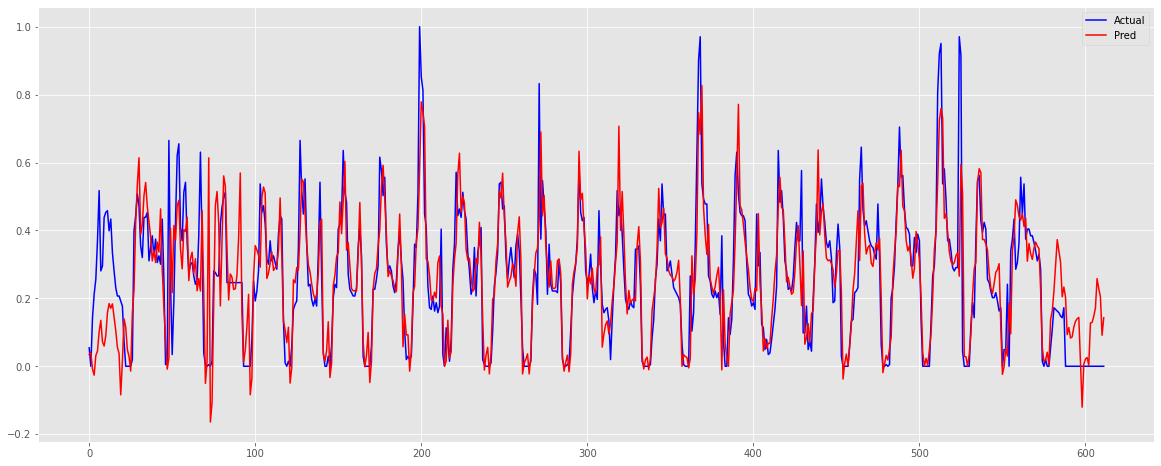

In [112]:
weather = pd.read_csv("weather.csv", encoding='cp949')
house_load_data = pd.read_csv("./etri_ess_house_data_220211/load_house_2022/house_load_6-1_2201.csv")
lstm_predictions = prediction(house_load_data, weather, (1,0,0), (2,1,1,24))

In [113]:
lstm_predictions

,prediction,load,familyID
time,,,
2022-01-06 12:00:00,70.561508,0.0,6-1
2022-01-06 13:00:00,80.355208,0.0,6-1
2022-01-06 14:00:00,-16.834956,160.0,6-1
2022-01-06 15:00:00,-53.350975,550.0,6-1
2022-01-06 16:00:00,63.567949,580.0,6-1
...,...,...,...
2022-01-31 19:00:00,523.995282,330.0,6-1
2022-01-31 20:00:00,465.966117,320.0,6-1
2022-01-31 21:00:00,415.664200,300.0,6-1


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[24] intercept   : AIC=inf, Time=13.12 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=-333.011, Time=0.39 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=-423.522, Time=6.43 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=7.05 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=-334.102, Time=0.44 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=-413.268, Time=1.01 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=-504.674, Time=36.07 sec
 ARIMA(1,0,0)(2,1,1)[24] intercept   : AIC=-516.493, Time=50.45 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=10.35 sec
 ARIMA(1,0,0)(2,1,2)[24] intercept   : AIC=inf, Time=55.48 sec
 ARIMA(1,0,0)(1,1,2)[24] intercept   : AIC=inf, Time=51.90 sec
 ARIMA(0,0,0)(2,1,1)[24] intercept   : AIC=-439.651, Time=49.27 sec
 ARIMA(2,0,0)(2,1,1)[24] intercept   : AIC=-514.760, Time=58.02 sec
 ARIMA(1,0,1)(2,1,1)[24] intercept   : AIC=-514.816, Time=53.12 sec
 ARIMA(0,0,1)(2,1,1)[24] intercept 

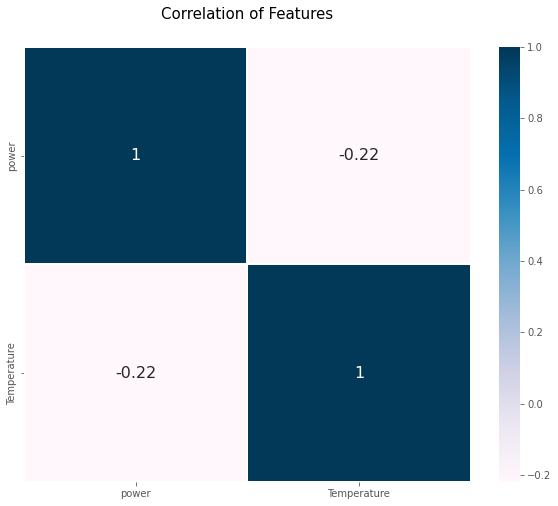

In [114]:
weather = pd.read_csv("weather.csv", encoding='cp949')
house_load_data = pd.read_csv("./etri_ess_house_data_220211/load_house_2022/house_load_14_2201.csv")
set_sarimax_model(house_load_data, weather)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[24] intercept   : AIC=inf, Time=16.81 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=-340.680, Time=0.63 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=-502.551, Time=8.33 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=13.07 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=-340.993, Time=1.26 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=-495.460, Time=1.94 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=-536.696, Time=43.24 sec
 ARIMA(1,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=49.57 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=11.93 sec
 ARIMA(0,0,0)(2,1,0)[24] intercept   : AIC=-376.974, Time=21.54 sec
 ARIMA(2,0,0)(2,1,0)[24] intercept   : AIC=-534.716, Time=45.29 sec
 ARIMA(1,0,1)(2,1,0)[24] intercept   : AIC=-534.726, Time=55.07 sec
 ARIMA(0,0,1)(2,1,0)[24] intercept   : AIC=-502.192, Time=31.31 sec
 ARIMA(2,0,1)(2,1,0)[24] intercept   : AIC=-533.110, Time=58.88 sec
 ARIMA(1,0,0)(2,1,0)[24]     

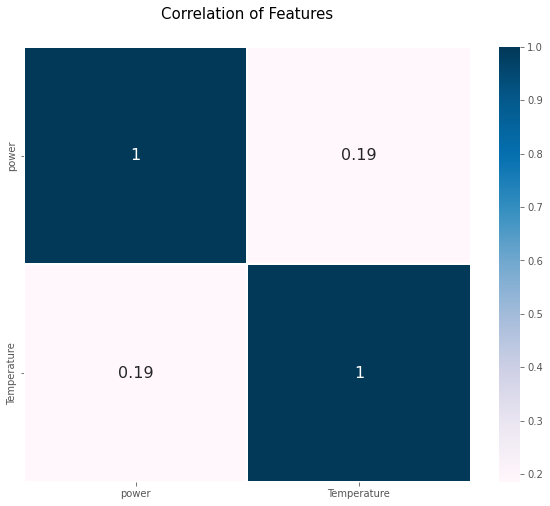

In [115]:
weather = pd.read_csv("weather.csv", encoding='cp949')
house_load_data = pd.read_csv("./etri_ess_house_data_220211/load_house_2022/house_load_17_2201.csv")
set_sarimax_model(house_load_data, weather)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[24] intercept   : AIC=inf, Time=15.40 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=-461.910, Time=0.63 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=-810.438, Time=8.60 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=9.62 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=-462.170, Time=0.58 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=-779.375, Time=1.72 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=-843.629, Time=56.14 sec
 ARIMA(1,0,0)(2,1,1)[24] intercept   : AIC=-872.076, Time=62.41 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=14.51 sec
 ARIMA(1,0,0)(2,1,2)[24] intercept   : AIC=-882.673, Time=68.25 sec
 ARIMA(1,0,0)(1,1,2)[24] intercept   : AIC=inf, Time=55.38 sec
 ARIMA(0,0,0)(2,1,2)[24] intercept   : AIC=-649.351, Time=56.59 sec
 ARIMA(2,0,0)(2,1,2)[24] intercept   : AIC=-908.500, Time=74.02 sec
 ARIMA(2,0,0)(1,1,2)[24] intercept   : AIC=inf, Time=66.26 sec
 ARIMA(2,0,0)(2,1,1)[24] intercept 

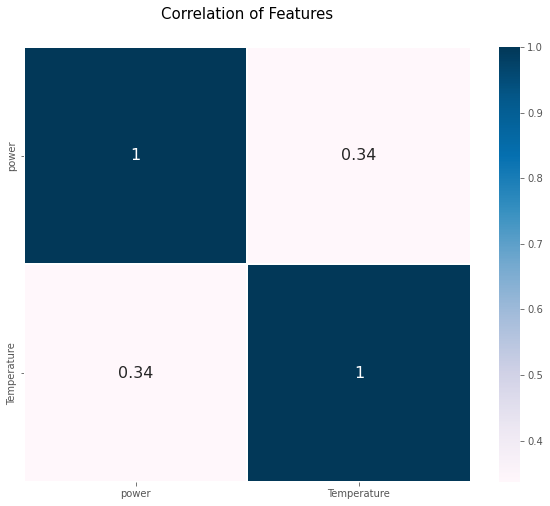

In [116]:
weather = pd.read_csv("weather.csv", encoding='cp949')
house_load_data = pd.read_csv("./etri_ess_house_data_220211/load_house_2022/house_load_22_2201.csv")
set_sarimax_model(house_load_data, weather)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[24] intercept   : AIC=inf, Time=12.25 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=-292.455, Time=0.49 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=-803.209, Time=7.93 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=7.47 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=-292.676, Time=0.58 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=-776.007, Time=1.08 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=inf, Time=46.57 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=9.81 sec
 ARIMA(1,0,0)(0,1,1)[24] intercept   : AIC=inf, Time=10.76 sec
 ARIMA(1,0,0)(2,1,1)[24] intercept   : AIC=-930.694, Time=49.45 sec
 ARIMA(1,0,0)(2,1,2)[24] intercept   : AIC=inf, Time=59.46 sec
 ARIMA(1,0,0)(1,1,2)[24] intercept   : AIC=inf, Time=53.80 sec
 ARIMA(0,0,0)(2,1,1)[24] intercept   : AIC=-488.835, Time=36.58 sec
 ARIMA(2,0,0)(2,1,1)[24] intercept   : AIC=-973.400, Time=52.34 sec
 ARIMA(2,0,0)(1,1,1)[24] intercept   : AIC=inf

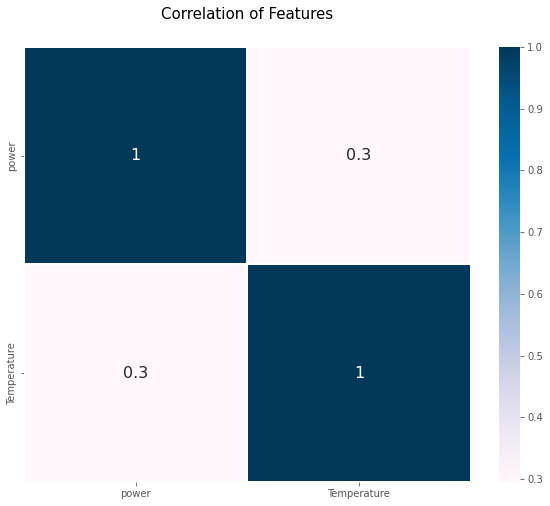

In [118]:
weather = pd.read_csv("weather.csv", encoding='cp949')
house_load_data = pd.read_csv("./etri_ess_house_data_220211/load_house_2022/house_load_32-1_2201.csv")
set_sarimax_model(house_load_data, weather)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[24] intercept   : AIC=inf, Time=13.29 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=-310.041, Time=0.51 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=-559.678, Time=11.08 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=6.03 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=-310.965, Time=0.41 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=-548.165, Time=0.96 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=-580.569, Time=35.73 sec
 ARIMA(1,0,0)(2,1,1)[24] intercept   : AIC=-640.980, Time=53.64 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=11.27 sec
 ARIMA(1,0,0)(2,1,2)[24] intercept   : AIC=-640.007, Time=58.71 sec
 ARIMA(1,0,0)(1,1,2)[24] intercept   : AIC=inf, Time=55.23 sec
 ARIMA(0,0,0)(2,1,1)[24] intercept   : AIC=-419.182, Time=32.96 sec
 ARIMA(2,0,0)(2,1,1)[24] intercept   : AIC=-640.565, Time=53.44 sec
 ARIMA(1,0,1)(2,1,1)[24] intercept   : AIC=-640.496, Time=54.79 sec
 ARIMA(0,0,1)(2,1,1)[24] inte

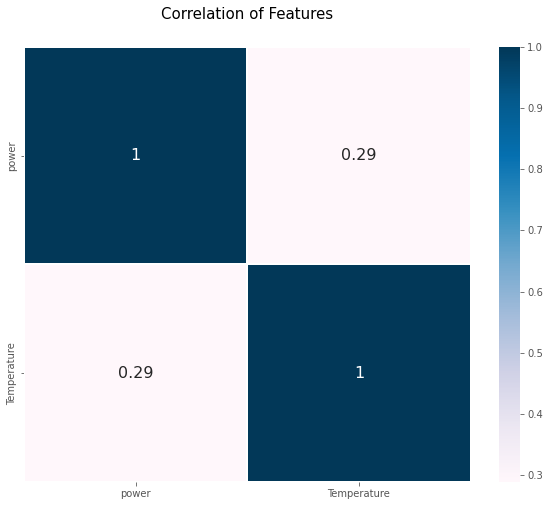

In [119]:
weather = pd.read_csv("weather.csv", encoding='cp949')
house_load_data = pd.read_csv("./etri_ess_house_data_220211/load_house_2022/house_load_34_2201.csv")
set_sarimax_model(house_load_data, weather)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[24] intercept   : AIC=inf, Time=12.33 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=-748.023, Time=1.05 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=-956.441, Time=7.34 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=9.83 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=-749.746, Time=0.48 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=-941.842, Time=0.83 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=-981.850, Time=31.42 sec
 ARIMA(1,0,0)(2,1,1)[24] intercept   : AIC=inf, Time=50.66 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=10.92 sec
 ARIMA(0,0,0)(2,1,0)[24] intercept   : AIC=-794.603, Time=28.68 sec
 ARIMA(2,0,0)(2,1,0)[24] intercept   : AIC=-980.523, Time=49.34 sec
 ARIMA(1,0,1)(2,1,0)[24] intercept   : AIC=-980.950, Time=48.82 sec
 ARIMA(0,0,1)(2,1,0)[24] intercept   : AIC=-952.036, Time=30.30 sec
 ARIMA(2,0,1)(2,1,0)[24] intercept   : AIC=-984.040, Time=59.25 sec
 ARIMA(2,0,1)(1,1,0)[24] inter

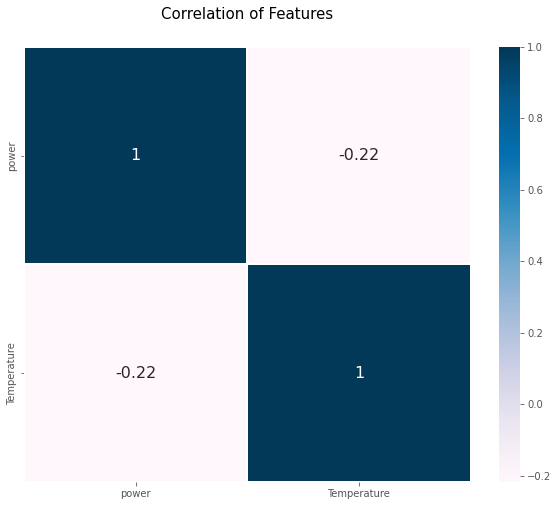

In [120]:
weather = pd.read_csv("weather.csv", encoding='cp949')
house_load_data = pd.read_csv("./etri_ess_house_data_220211/load_house_2022/house_load_37_2201.csv")
set_sarimax_model(house_load_data, weather)

       R2    MAE   Corr  RMSE     RRMSE
0  61.792  0.082  0.794  0.12  0.457928


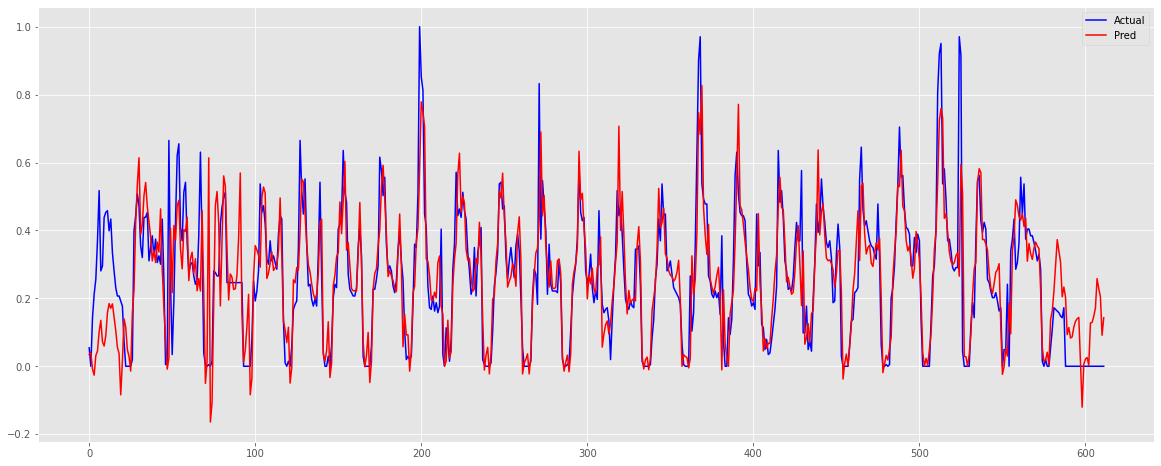

In [121]:
weather = pd.read_csv("weather.csv", encoding='cp949')
house_load_data = pd.read_csv("./etri_ess_house_data_220211/load_house_2022/house_load_6-1_2201.csv")
lstm_predictions_6 = prediction(house_load_data, weather, (1,0,0), (2,1,1,24))

       R2    MAE   Corr   RMSE    RRMSE
0  61.214  0.093  0.792  0.142  0.50675


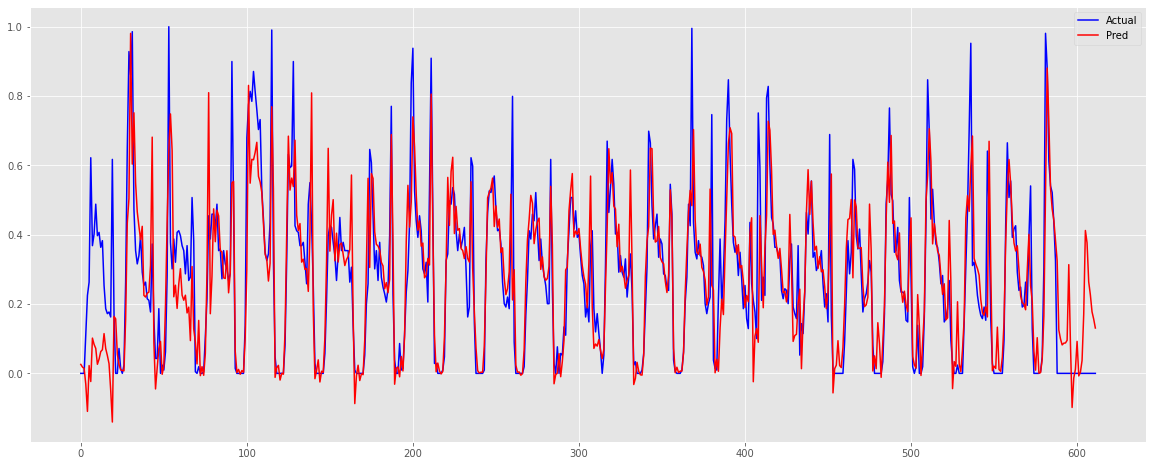

In [122]:
weather = pd.read_csv("weather.csv", encoding='cp949')
house_load_data = pd.read_csv("./etri_ess_house_data_220211/load_house_2022/house_load_14_2201.csv")
lstm_predictions_14 = prediction(house_load_data, weather, (1,0,0), (2,1,1,24))

       R2    MAE   Corr   RMSE     RRMSE
0  22.913  0.091  0.551  0.142  0.694191


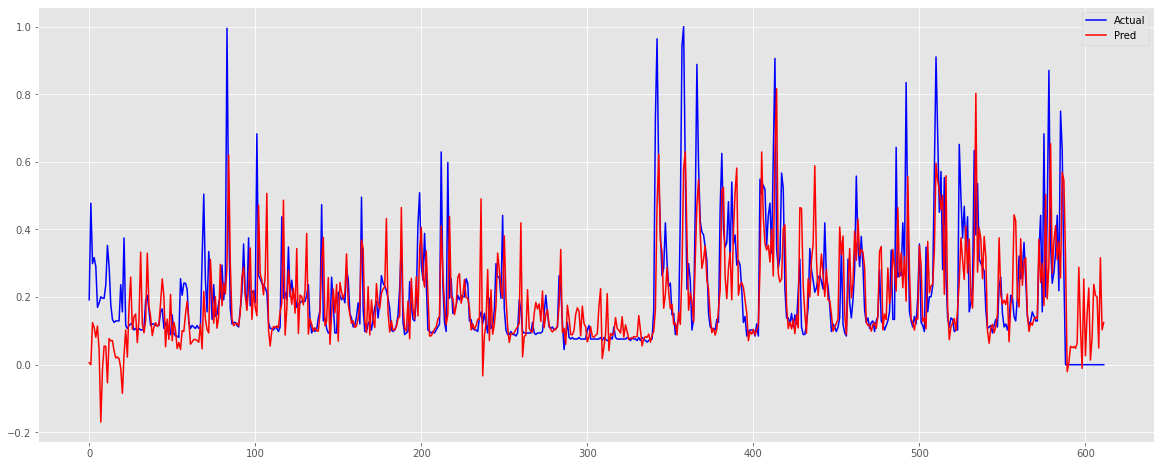

In [123]:
weather = pd.read_csv("weather.csv", encoding='cp949')
house_load_data = pd.read_csv("./etri_ess_house_data_220211/load_house_2022/house_load_17_2201.csv")
lstm_predictions_17 = prediction(house_load_data, weather, (1,0,0), (2,1,0,24))

       R2    MAE   Corr   RMSE     RRMSE
0  81.086  0.049  0.904  0.115  0.721594


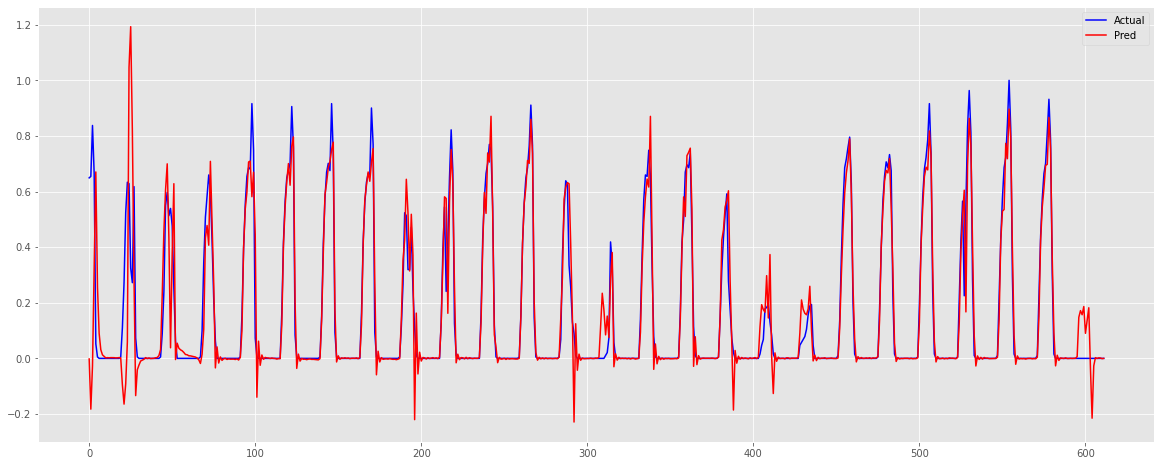

In [124]:
weather = pd.read_csv("weather.csv", encoding='cp949')
house_load_data = pd.read_csv("./etri_ess_house_data_220211/load_house_2022/house_load_22_2201.csv")
lstm_predictions_22 = prediction(house_load_data, weather, (1,0,1), (2,1,2,24))

       R2    MAE   Corr   RMSE     RRMSE
0  86.391  0.044  0.933  0.112  0.635464


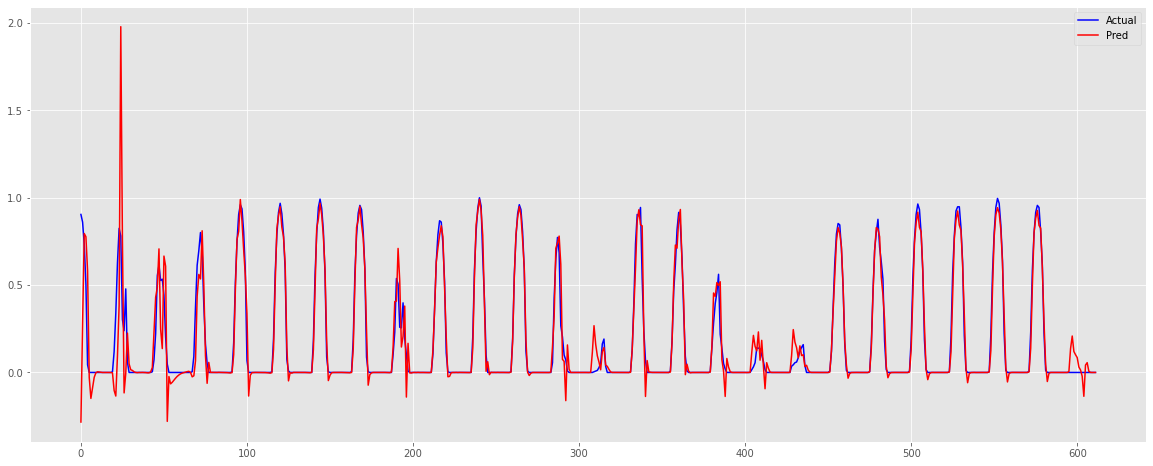

In [125]:
weather = pd.read_csv("weather.csv", encoding='cp949')
house_load_data = pd.read_csv("./etri_ess_house_data_220211/load_house_2022/house_load_32-1_2201.csv")
lstm_predictions_32 = prediction(house_load_data, weather, (4,0,0), (2,1,2,24))

       R2    MAE   Corr   RMSE     RRMSE
0  74.118  0.061  0.868  0.139  0.976006


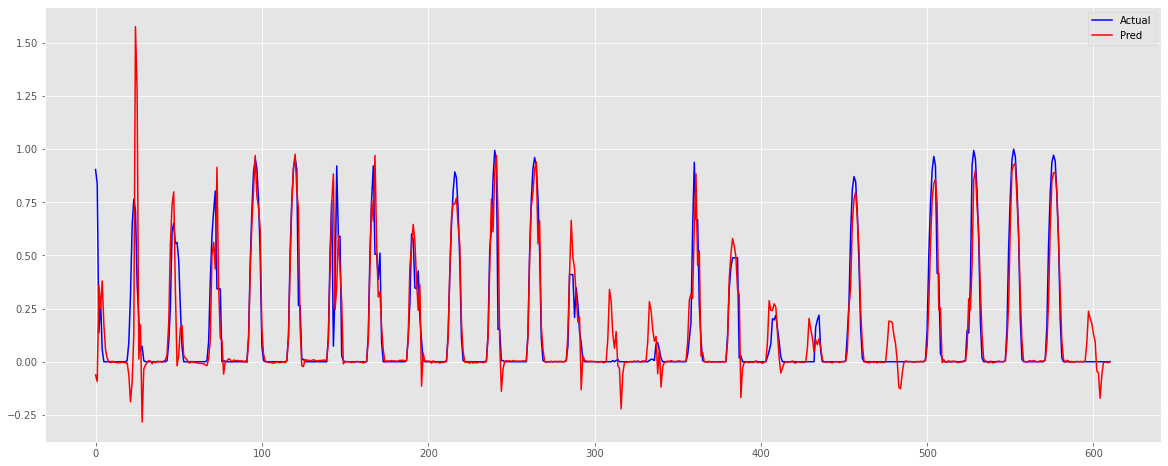

In [126]:
weather = pd.read_csv("weather.csv", encoding='cp949')
house_load_data = pd.read_csv("./etri_ess_house_data_220211/load_house_2022/house_load_34_2201.csv")
lstm_predictions_34 = prediction(house_load_data, weather, (1,0,0), (2,1,1,24))

       R2    MAE   Corr   RMSE     RRMSE
0  73.442  0.052  0.861  0.085  0.403683


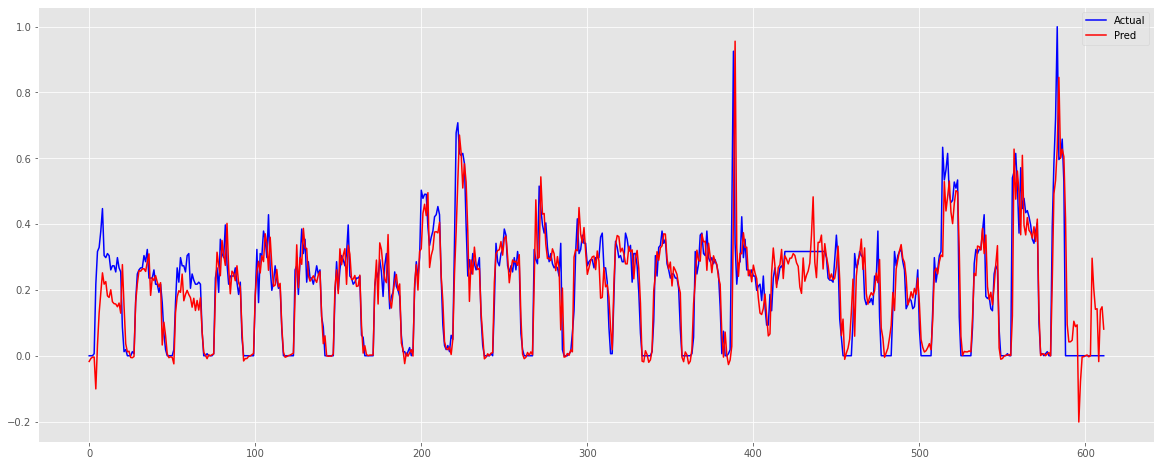

In [127]:
weather = pd.read_csv("weather.csv", encoding='cp949')
house_load_data = pd.read_csv("./etri_ess_house_data_220211/load_house_2022/house_load_37_2201.csv")
lstm_predictions_37 = prediction(house_load_data, weather, (2,0,1), (2,1,0,24))

In [128]:
lstm_predictions_6['date'] = lstm_predictions_6.index
lstm_predictions_14['date'] = lstm_predictions_14.index
lstm_predictions_17['date'] = lstm_predictions_17.index
lstm_predictions_22['date'] = lstm_predictions_22.index
lstm_predictions_32['date'] = lstm_predictions_32.index
lstm_predictions_34['date'] = lstm_predictions_34.index
lstm_predictions_37['date'] = lstm_predictions_37.index

In [129]:
result = pd.concat([lstm_predictions_6,
                   lstm_predictions_14,
                   lstm_predictions_17,
                   lstm_predictions_22,
                   lstm_predictions_32,
                   lstm_predictions_34,
                   lstm_predictions_37])
result.reset_index(inplace=True)
result.drop(['time'],axis=1,inplace=True)

In [130]:
result.to_csv('C:load_prediction.csv')